# Get the data
Import and take a look.  Note that the Sentiment is column 5 and tweet is column 15

In [ ]:
import pandas as pd
import numpy as np
data=pd.read_csv("./Downloads/Sentiment.csv")

In [ ]:
data.head()

## Build a map
Ok i cheated.  I used this handy dandy function and the Counter() method from Python.

If you are not familiar with collections, check them out.  Counter() and defaultdict() are super handy for general data wrangling.

In [ ]:
import collections
def build_dataset(words):
    count = collections.Counter(words).most_common()
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

### Split
Need test and train sets.  Split by 75%

Mean professor also forgot to mention that there is a 3rd class.  We can either train for it or drop it.

In [ ]:
n=int(np.floor(data.shape[0]*0.75))





In [ ]:
train = data[0:n]
test = data[n:]
train = train[train['sentiment']!='Neutral']
test = test[test['sentiment']!='Neutral']

### Build a word list.

Iterate through the entire data set, split the tweets into tokens and append it to one giant list.
This is a bit of a 'brute force' method, but it works.

Alternatively, one could build a map directly from here by using the folling psuedo code
```
word_map=dict()
for i in data['text']:
    words = i.split()
    for i in words:
        if word not in word_map:  # this is psuedo code
            add it!               # so is this
        else:
            pass        
```

I'll stick with my big word list cause it works.

Note their are also faster ways to interate through a dataframe.  

In [ ]:
word_list=[]
for i in data['text']:
    word_list = word_list + i.split()
    

In [ ]:
len(word_list)

Now I build my maps.  Since I was uncool and ganked my code from someone else, there is a brute force way afterwards

In [ ]:
enc, dec = build_dataset(word_list)

In [ ]:
dec

In [ ]:
enc

### Tharg smash problem!

In [ ]:
#method 1
words = list(set(word_list))  # get a list of unique words.
counter=0
enc_brute1={}
dec_brute1={}
for i in words:
    enc_brute1[i] = counter
    dec_brute1[counter] = i
    counter = counter + 1

In [108]:
enc_brute1  #note that they are in a different order.  Doesn't matter.  Its just a map

{}

In [109]:
# What is that set stuff....I had no clue!!!
# Method 2
text_df = pd.DataFrame({"words":word_list})
words = text_df['words'].unique()
counter=0
enc_brute2={}
dec_brute2={}
for i in words:
    enc_brute2[i] = counter
    dec_brute2[counter] = i
    counter = counter + 1

In [110]:
enc_brute2  #different order still, but makes some sense.  

{'RT': 0,
 '@NancyLeeGrahn:': 1,
 'How': 2,
 'did': 3,
 'everyone': 4,
 'feel': 5,
 'about': 6,
 'the': 7,
 'Climate': 8,
 'Change': 9,
 'question': 10,
 'last': 11,
 'night?': 12,
 'Exactly.': 13,
 '#GOPDebate': 14,
 '@ScottWalker:': 15,
 "Didn't": 16,
 'catch': 17,
 'full': 18,
 '#GOPdebate': 19,
 'night.': 20,
 'Here': 21,
 'are': 22,
 'some': 23,
 'of': 24,
 "Scott's": 25,
 'best': 26,
 'lines': 27,
 'in': 28,
 '90': 29,
 'seconds.': 30,
 '#Walker16': 31,
 'http://t.co/ZSfF…': 32,
 '@TJMShow:': 33,
 'No': 34,
 'mention': 35,
 'Tamir': 36,
 'Rice': 37,
 'and': 38,
 'was': 39,
 'held': 40,
 'Cleveland?': 41,
 'Wow.': 42,
 '@RobGeorge:': 43,
 'That': 44,
 'Carly': 45,
 'Fiorina': 46,
 'is': 47,
 'trending': 48,
 '--': 49,
 'hours': 50,
 'after': 51,
 'HER': 52,
 'debate': 53,
 'above': 54,
 'any': 55,
 'men': 56,
 'just-completed': 57,
 'says': 58,
 "she's": 59,
 'on': 60,
 '…': 61,
 '@DanScavino:': 62,
 'w/': 63,
 '@realDonaldTrump': 64,
 'delivered': 65,
 'highest': 66,
 'ratings': 

Now I need to shift my padding to account for the '<pad>' and '<start>' tokens.  I also need to account for that in my decoders.  If you chose to use one of the other decoders, they need to be shifted as well.
    
Decoder doesn't need shifting, just a map of the proper number.  Since all the words are off by 2 in the encoder, we can subtract 2 from the encoder result to get the decoder key.  However, entries -1 and -2 are not in the decoder, so I need to add them in.  <i> This is why I got goofy results on Tuesday night as I did the deocder wrong when I tried to switch back to text. </i>

In [111]:
for i in enc:
    enc[i] = enc[i]+2

In [112]:
enc['pad']=0
enc['<start>']=1
dec[-2]='pad'
dec[-1]='<start>'

### Make some numbers
For each tweet, split up the tweet into words, look up each word in the encoder (line 4,15).  Then append it to a list(line 5, 16).  Finally take the target and encode it 1 for positive and 0 for negative

In [113]:
x_train=[]
y_train=[]
for i in range(train.shape[0]):
    tmp = [enc[j] for j in train.iloc[i,15].split()]
    x_train.append(tmp)
    if train.iloc[i,5]=='Positive':
        y=1
    else:
        y=0
    y_train.append(y)
    
x_test=[]
y_test=[]
for i in range(test.shape[0]):
    tmp = [enc[j] for j in test.iloc[i,15].split()]
    x_test.append(tmp)
    if test.iloc[i,5]=='Positive':
        y=1
    else:
        y=0
    y_test.append(y)

I now have several lists of list (a list, where the list elements are lists)

Lets try and find a good sequence length.  In this case, everything was 29 tokens or less.

In [114]:
print(max([len(i) for i in x_train]))
print(max([len(i) for i in x_test]))

29
27


Lets make sure Dr. Nutjob did his encoding correctly.

In [115]:
tmp = [enc[j] for j in train.iloc[0,15].split()]
tmp

[4,
 2656,
 1240,
 2399,
 5,
 664,
 89,
 35,
 231,
 1346,
 36,
 242,
 9,
 6866,
 241,
 1489,
 15,
 2657,
 2658,
 978,
 11406]

In [116]:
train.iloc[0,15]  #original tweet

"RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…"

In [117]:
[dec[i-2] for i in tmp]  #remember that the decoder was not shifted, so i need to subtract 2 to get the correct word

['#GOPDebate',
 'seconds.',
 'Me',
 '@WayneDupreeShow:',
 'to',
 'Great',
 'It',
 'but',
 'America',
 'Kasich,',
 'News',
 '#GOPDebate…',
 'is',
 'trending',
 'because',
 '(Vine',
 'for',
 'held',
 'delivered',
 'cut',
 'Rice']

How would we do this if we had really long tweet lengths?

Plot a histogram and get an idea of where most of the data lies

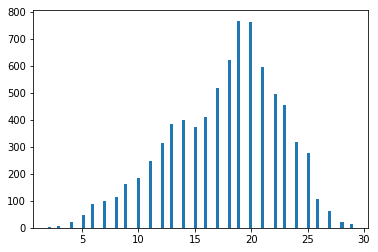

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([len(i) for i in x_train],bins=100)
plt.show()

In [119]:
import scipy
lengths = [len(i) for i in x_train]
print(scipy.quantile(lengths,0.85)) #what value contains 85% of my training data (i didnt add test data)
print(scipy.quantile(lengths,0.90)) # 90%
print(scipy.quantile(lengths,0.95)) # 95%
print(scipy.quantile(lengths,0.99)) # 99%

23.0
24.0
25.0
27.0


Remember the IMDB dataset, that is a good example of how to pick a cutoff.  We plot the histogram and find quantiles and see that more than 90% of  our data is less than 500 tokens.  My personal choice may have been to do 600 vs 500 as its the 95% quantile, but hey, I'm just a (adjunct) professor of data science.

In [121]:
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data(num_words=5000)


378.0
457.0
598.0
914.0


(array([2., 1., 2., ..., 0., 0., 1.]),
 array([   7.    ,    8.2435,    9.487 , ..., 2491.513 , 2492.7565,
        2494.    ]),
 <a list of 2000 Patch objects>)

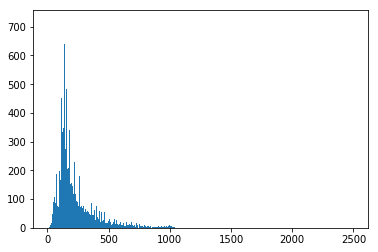

In [127]:
lengths_imdb = [len(i) for i in X_train_imdb]
lengths_imdb = lengths_imdb + [len(i) for i in X_test_imdb]


print(scipy.quantile(lengths_imdb,0.85)) #what value contains 85% of my training data (i didnt add test data)
print(scipy.quantile(lengths_imdb,0.90)) # 90%
print(scipy.quantile(lengths_imdb,0.95)) # 95%
print(scipy.quantile(lengths_imdb,0.99)) # 99%

plt.hist(lengths_imdb,bins=2000)

Ok now i need to add my start token and then pad sequences to be 30 (29+1 start token) tokens long, equal to my longest sequence

In [128]:
x_train=[[1]+i for i in x_train]
x_test=[[1]+i for i in x_test]

In [129]:
from keras.preprocessing import sequence

max_words = 30
x_train = sequence.pad_sequences(x_train, maxlen=max_words)
x_test = sequence.pad_sequences(x_test, maxlen=max_words)

Only Arrays are allowed from here on out.  If only there was an easy way to make a list into an array....

In [131]:
x_train=np.asarray(x_train)
x_test=np.asarray(x_test)
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)

Borrowing from our previous code, lets shove this into a simple LSTM.  Embed each word to 100 dimensions, input length is max_words (30). I changed to vanilla LSTM to add dropout (regularizaion is our friend!) so I lose some speed, but this is a short example.  Not that we start to overfit and epoch 5.  Needs tuning but we have a good first exercise.

In [138]:
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import  LSTM, SimpleRNN, GRU
#from keras.layers import LSTM , SimpleRNN, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# create the model
embedding_vecor_length = 100
model1 = Sequential()
top_words = len(enc)
model1.add(Embedding(top_words, embedding_vecor_length, input_length=max_words))
model1.add(LSTM(100,recurrent_dropout=0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())
model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 30, 100)           3165800   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 3,246,301
Trainable params: 3,246,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 7872 samples, validate on 2857 samples
Epoch 1/10
7872/7872 [==============================] - 12s 2ms/step - loss: 0.4726 - acc: 0.8008 - val_loss: 0.3650 - val_acc: 0.8442
Epoch 2/10
7872/7872 [==============================] - 10s 1ms/step - loss: 0.2207 - acc: 0.9154 - val_loss: 0.3630 - val_acc: 0.8481
Epoch 3/10
7872/7872 [==============================] - 10s 1ms/step - lo

In [ ]:
X_train[0]